# Linear Regression Models


Linear regression is a very good choice for modeling a continuous target, assuming that our features and target have certain qualities.

In this chapter, we will cover the following topics:
- key concepts
- linear regression and gradient descent
- using classical linear regression
- using lasso regression
- using non-linear regression
- regression with gradient descent

## Key Concepts

### Key assumptions of linear regression models

- there is a linear relationship between features (independent variables) and the target (dependent variable)
- the residuals (the difference between actual and predicted values) are normally distributed
- the residuals are independent across observations
- the variance of residuals is constant


Our residuals are sometimes not normally distributed. This can indicate that our model is less accurate along certain ranges of our target. This can happen when the relationship with the target is __nonlinear__.

There are several reasons why residuals may not be independent. This is often the case with time series data. For a model of daily stock price, the residuals may be correlated for adjacent days. This is referred to as __autocorrelation__.

It is not uncommon for our residuals to have greater variability along different ranges of a feature. __Heteroscedasticity__ is a condition where the variance of the residuals is not constant across the range of the independent variable. Heteroscedasticity can lead to non-normally distributed residuals because the variance of the residuals is not constant.

## Linear regression and ordinary least squares

OLS selects coefficients that minimize the sum of the squared distance between the actual target values and the predicted values.

## Linear regresion and gradient descent

We can use gradient descent, rather than OLS, to estimate our linear regression parameters. Gradient descent iterates over possible coefficient values to find those that minimize the residual sum of squares. 

It starts with with random coefficient values and calculate the sum of the squared errors for that iteration. Then, it generates new values for coefficients that yield smaller residuals that those from the previous step. 

We specify a learning rate when using gradient descent. The learning rate determines the amount of improvement in residuals at each step.

Gradient descent can often be a good choice when working with very large datasets. It may be the the only choice if the full dataset does not fit into your machine's memory.

## Using classical linear regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skmet
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from data.load import load_fossilfueltaxrate14
from preprocfunc import OutlierTrans

In [2]:
ff_tax_rate14 = load_fossilfueltaxrate14()
ff_tax_rate14.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, AFG to ZWE
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   country                    154 non-null    object 
 1   region                     154 non-null    object 
 2   region_wb                  154 non-null    object 
 3   year                       154 non-null    int64  
 4   gas_tax_imp                154 non-null    float64
 5   bmgap_diesel_spotprice_la  146 non-null    float64
 6   fuel_income_dependence     152 non-null    float64
 7   national_income_per_cap    152 non-null    float64
 8   VAT_Rate                   151 non-null    float64
 9   gov_debt_per_gdp           139 non-null    float64
 10  polity                     151 non-null    float64
 11  democracy_polity           151 non-null    float64
 12  autocracy_polity           151 non-null    float64
 13  goveffect                  154 non-null    float64
 1

In [3]:
ff_tax_rate14.head()

,country,region,region_wb,year,gas_tax_imp,bmgap_diesel_spotprice_la,fuel_income_dependence,national_income_per_cap,VAT_Rate,gov_debt_per_gdp,polity,democracy_polity,autocracy_polity,goveffect,democracy_index,democracy,nat_oil_comp,nat_oil_comp_state,motorization_rate
countrycode,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Asia + Pacific,South Asia,2014,0.272083,0.454003,0.000000,630.0,3.5,8.700291,-1.0,0.0,0.0,-1.33,0.374292,0,0.0,0.0,0.046837
AGO,Angola,Africa,Sub-Saharan Africa,2014,-0.150713,-0.225997,32.499064,5010.0,10.0,39.809857,-2.0,0.0,0.0,-1.12,0.220831,0,1.0,1.0,0.031178
ALB,Albania,Europe + North America,Europe & Central Asia,2014,1.099843,0.974003,2.292260,4540.0,20.0,70.027863,9.0,1.0,0.0,-0.09,0.529352,1,1.0,1.0,0.156796
ARE,UAE,Middle East,Middle East & North Africa,2014,-0.334680,-0.095997,18.048514,44370.0,0.0,NaN,-8.0,0.0,1.0,1.44,0.120726,0,1.0,1.0,0.212716
ARG,Argentina,Latin America & Caribbean,Latin America & Caribbean,2014,0.705042,0.594003,2.954761,12350.0,21.0,43.586674,8.0,1.0,0.0,-0.16,0.782024,1,1.0,0.0,0.313479


### Pre-processing the data for our regression model

We separate the features into numerical and binary features. We will put `motorization_rate` into a special category because we anticipate having to do a little more with it than with the other features:

In [4]:
num_cols = [
    "fuel_income_dependence",
    "national_income_per_cap",
    "VAT_Rate",
    "gov_debt_per_gdp",
    "polity",
    "goveffect",
    "democracy_index",
]
dummy_cols = [
    "democracy_polity",
    "autocracy_polity",
    "democracy",
    "nat_oil_comp",
    "nat_oil_comp_state",
]
spec_cols = ["motorization_rate"]
target_col = ["gas_tax_imp"]

In [5]:
ff_tax_rate14[target_col + num_cols + spec_cols].agg(
    ["count", "min", "median", "max"]
).T

,count,min,median,max
gas_tax_imp,154.0,-0.800521,0.524398,1.734047
fuel_income_dependence,152.0,0.000000,0.135366,34.428455
national_income_per_cap,152.0,260.000000,6050.000000,104540.000000
VAT_Rate,151.0,0.000000,16.500000,27.000000
gov_debt_per_gdp,139.0,0.545311,39.301174,194.755470
polity,151.0,-10.000000,7.000000,10.000000
goveffect,154.0,-2.040000,-0.145000,2.180000
democracy_index,152.0,0.025098,0.572551,0.930208
motorization_rate,127.0,0.002870,0.198289,0.810421


^ Our target `gax_tax_imp` has a median value of 0.52.

- more than half of the countries have a `polity` score of 7 or higher; 10 is the highest possible `polity` score, meaning most democratic
- most countries have a negative value for government effectiveness (`goveffect`)
`democracy_index` is a very similar measure to `polity`, though there is more variation

Let's also look at tehe distribution of the binary features. We must set `normalize` to `True` to generate ratios rather than counts.


In [6]:
ff_tax_rate14[dummy_cols].apply(pd.value_counts, normalize=True).T

,0.0,1.0
democracy_polity,0.410596,0.589404
autocracy_polity,0.887417,0.112583
democracy,0.415584,0.584416
nat_oil_comp,0.539474,0.460526
nat_oil_comp_state,0.769737,0.230263


^ observations:
- the `democracy_polity` and `autocracy_polity` featuers are just binarized versions of the `polity` feature; very high `polity` scores get `democracy_polity` values of 1, while very low `polity` scores get `autocracy_polity` values of 1.
- similarly, `democracy` is a dummy feature of those countries with high `democracy_index` values.
- interestingly, nearly half of the countries (0.46) have a national oil company, and almost a quarter (0.23) have a state-owned national oil company

Preprocessing steps:
- we need to do some work on the missing values for several features
- we also need to do some scaling, but there is no need to do any encoding because we can use the binary featuers as they are
- some features are correlated, so we need to do some feature elimination

In [7]:
target = ff_tax_rate14[target_col]
features = ff_tax_rate14[num_cols + dummy_cols + spec_cols]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=0
)

In [8]:
std_trans = make_pipeline(
    OutlierTrans(2), SimpleImputer(strategy="median"), StandardScaler()
)
cat_trans = make_pipeline(SimpleImputer(strategy="most_frequent"))
spc_trans = make_pipeline(OutlierTrans(2), StandardScaler())
col_trans = ColumnTransformer(
    [
        ("stand", std_trans, num_cols),
        ("cat", cat_trans, dummy_cols),
        ("spec", spc_trans, spec_cols),
    ],
    verbose_feature_names_out=False,
)

### Running and evaluating our linear model

In [10]:
lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=7)

pipe1 = make_pipeline(col_trans, KNNImputer(n_neighbors=5), rfe, lr)

ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())
ttr.fit(X_train, y_train)

sel_cols = X_train.columns[ttr.regressor_.named_steps["rfe"].support_]
coefs = ttr.regressor_.named_steps["linearregression"].coef_

list(zip(sel_cols, coefs))

[('VAT_Rate', 0.44753064726665703),
 ('gov_debt_per_gdp', 0.12368913577287777),
 ('goveffect', 0.17926454403985637),
 ('autocracy_polity', -0.22100930246392825),
 ('nat_oil_comp', -0.15726572731003757),
 ('nat_oil_comp_state', -0.701345468663265),
 ('motorization_rate', 0.13855012574945397)]

In [11]:
y_pred = ttr.predict(X_test)
pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.gas_tax_imp - pred_df.prediction

In [12]:
pred_df.resid.agg(["mean", "median", "skew", "kurtosis"])

mean       -0.088965
median     -0.128688
skew        0.613088
kurtosis    0.037539
Name: resid, dtype: float64

^ There is a little positive skew and some overall bias; the residuals are negative overall.

#### Metrics

In [13]:
print(
    "Mean Absolute Error: {:.2f}, R-squared: {:.2f}".format(
        skmet.mean_absolute_error(y_test, y_pred), skmet.r2_score(y_test, y_pred)
    )
)

MAE: 0.23, R-squared: 0.75


^ We get a mean absolute error of 0.23. That's not a great average error, given that the median value for the gas tax price is 0.52. The r-squared is decent, however.

It is usually helpful to look at a plot of the residuals. 

(-0.5625, 0.8125)

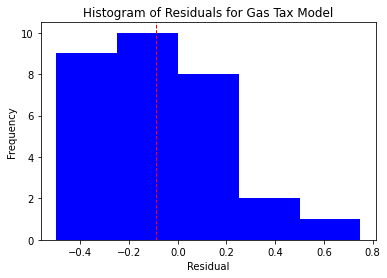

In [14]:
plt.hist(pred_df.resid, color="blue", bins=np.arange(-0.5, 1.0, 0.25))
plt.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Histogram of Residuals for Gas Tax Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim()

^ This plot shows the positive skew. Morever, our model is somewhat more likely to over-predict the gas tax than under-predict it. (The residual is negative when the prediction is greater than the actual target value). 

Text(0, 0.5, 'Residuals')

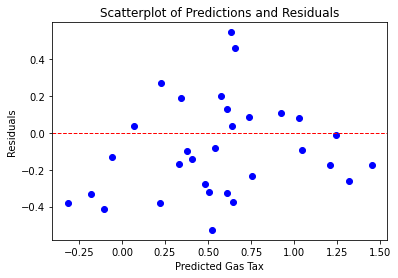

In [15]:
plt.scatter(pred_df.prediction, pred_df.resid, color="blue")
plt.axhline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gas Tax")
plt.ylabel("Residuals")

^ Here, overprediction occurs throughout the range of predicted values, but there are no underprediction (positive residuals) with predictions below 0 or above 1. This should give us some doubts about our assumption of linearity.

### Improving our model evaluation

Instead of using 80% of our data, we will use 90%, and k-fold cross-validation.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=1
)

In [23]:
kf = KFold(n_splits=3, shuffle=True, random_state=0)

In [24]:
scores = cross_validate(
    ttr,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=("r2", "neg_mean_absolute_error"),
    n_jobs=1,
)

#### Metrics

In [27]:
print(
    "Mean Absolute Error: {:.2f}, R-squared: {:.2f}".format(
        scores["test_neg_mean_absolute_error"].mean(), scores["test_r2"].mean()
    )
)

Mean Absolute Error: -0.26, R-squared: 0.59


^ The scores are not very impressive. We do not end up explaining as much of the variance as we would like.

## Using lasso regression

One strategy to reduce the likelihood of overfitting is to use __regularization__.

Lasso regression uses L1 regularization, which penalizes the absolute value of the coefficients. Ridge regression is similar. It uses L2 regularization, which penalizes the squared values of the coefficients Elastic net regression uses both L1 and L2 regularization.

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as skmet
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso  # Instead of LinearRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from data.load import load_fossilfueltaxrate14
from preprocfunc import OutlierTrans

In [30]:
ff_tax_rate14 = load_fossilfueltaxrate14()

In [31]:
num_cols = [
    "fuel_income_dependence",
    "national_income_per_cap",
    "VAT_Rate",
    "gov_debt_per_gdp",
    "polity",
    "goveffect",
    "democracy_index",
]
dummy_cols = [
    "democracy_polity",
    "autocracy_polity",
    "democracy",
    "nat_oil_comp",
    "nat_oil_comp_state",
]
spec_cols = ["motorization_rate"]
target_col = ["gas_tax_imp"]

In [32]:
target = ff_tax_rate14[target_col]
features = ff_tax_rate14[num_cols + dummy_cols + spec_cols]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=0
)

In [39]:
std_trans = make_pipeline(
    OutlierTrans(2), SimpleImputer(strategy="median"), StandardScaler()
)
cat_trans = make_pipeline(SimpleImputer(strategy="most_frequent"))
spec_trans = make_pipeline(OutlierTrans(2), StandardScaler())
col_trans = ColumnTransformer(
    [
        ("std", std_trans, num_cols),
        ("cat", cat_trans, dummy_cols),
        ("spec", spec_trans, spec_cols),
    ],
    verbose_feature_names_out=False,
)

Now, we are ready to fit our model. We will start with a fairly conservative alpha of 0.1.
The higher the alpha, the greater the penalties for our coefficients. 
At 0, we get the same results as with linear regression. 


In addition to column transformation and lasso regression, our pieline uses KNN imputation for missing values,. We will also use the target transformer to scale the gasoline tax target. We will pass the pipeline we just created to the regressor parameter of the target transformer before we fit it:

In [43]:
lasso = Lasso(alpha=0.1, fit_intercept=False)
pipe1 = make_pipeline(col_trans, KNNImputer(n_neighbors=5), lasso)

ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())
ttr.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('std',
                                                                                       Pipeline(steps=[('outliertrans',
                                                                                                        OutlierTrans(threshold=2)),
                                                                                                       ('simpleimputer',
                                                                                                        SimpleImputer(strategy='median')),
                                                                                                       ('standardscaler',
                                                                                                        StandardScaler())]),
                                                                                       ['fuel_income_dependence',
                                                                                        'national_income_per_cap',
                                                                                        'VAT_Rate',
                                                                                        'gov_debt_per_gdp',
                                                                                        'polity...
                                                                                       ['democracy_polity',
                                                                                        'autocracy_polity',
                                                                                        'democracy',
                                                                                        'nat_oil_comp',
                                                                                        'nat_oil_comp_state']),
                                                                                      ('spec',
                                                                                       Pipeline(steps=[('outliertrans',
                                                                                                        OutlierTrans(threshold=2)),
                                                                                                       ('standardscaler',
                                                                                                        StandardScaler())]),
                                                                                       ['motorization_rate'])],
                                                                        verbose_feature_names_out=False)),
                                                     ('knnimputer',
                                                      KNNImputer()),
                                                     ('lasso',
                                                      Lasso(alpha=0.1,
                                                            fit_intercept=False))]),
                           transformer=StandardScaler())

In [44]:
coefs = ttr.regressor_["lasso"].coef_
list(zip(coefs, num_cols + dummy_cols + spec_cols))

[(-0.0026505240129232185, 'fuel_income_dependence'),
 (0.0, 'national_income_per_cap'),
 (0.43472262042825904, 'VAT_Rate'),
 (0.10927136643326679, 'gov_debt_per_gdp'),
 (0.006825858127837552, 'polity'),
 (0.15823493727828816, 'goveffect'),
 (0.09622123660935214, 'democracy_index'),
 (0.0, 'democracy_polity'),
 (-0.0, 'autocracy_polity'),
 (0.0, 'democracy'),
 (-0.0, 'nat_oil_comp'),
 (-0.21996382457812438, 'nat_oil_comp_state'),
 (0.016680304258453117, 'motorization_rate')]

^ Let's take a look at the coefficients from lasso regression. If we compare them to the coefficients from lienar regression in the previous section, we notice that we end up selecting the same features. Those features that were eliminated with recursive feature selection are largely the same ones that get near zero values with lasso regression.

In [50]:
y_pred = ttr.predict(X_test)
pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)


pred_df["resid"] = pred_df.gas_tax_imp - pred_df.prediction
pred_df.resid.agg(["mean", "median", "skew", "kurtosis"])

mean       -0.058844
median     -0.066457
skew        0.329402
kurtosis    0.095229
Name: resid, dtype: float64

^ Let's look at the predictions and residuals of this model. The residuals looks decent, with little bias and not much skew.

#### Metrics

In [52]:
print(
    "Mean Absolute Error: {:.2f}, R-squared: {:.2f}".format(
        skmet.mean_absolute_error(y_test, y_pred), skmet.r2_score(y_test, y_pred)
    )
)

Mean Absolute Error: 0.24, R-squared: 0.68


^ Let's also generate the mean absolute error and r-squared. These are not impressive scores. The r-square is lower than with linear regression, but the mean absolute error is about the same.

(-0.5625, 0.8125)

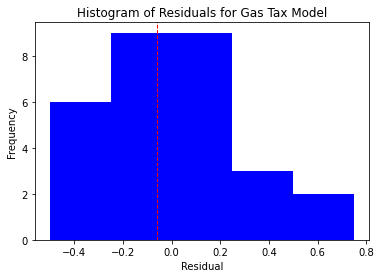

In [55]:
plt.hist(pred_df.resid, color="blue", bins=np.arange(-0.5, 1.0, 0.25))
plt.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Histogram of Residuals for Gas Tax Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.xlim()

^ The distribution of the residuals is quite similar to the linear regression model.

Text(0, 0.5, 'Residuals')

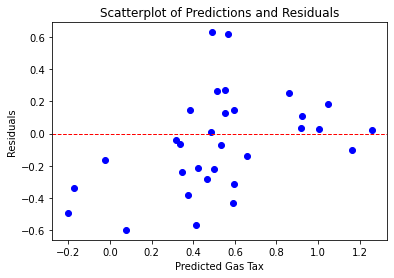

In [54]:
plt.scatter(pred_df.prediction, pred_df.resid, color="blue")
plt.axhline(0, color="red", linestyle="dashed", linewidth=1)
plt.title("Scatterplot of Predictions and Residuals")
plt.xlabel("Predicted Gas Tax")
plt.ylabel("Residuals")

^ Our model is likely to over-predict at the lower ranges and under-predict at the upper range. This is a change from the linear model, where we consistently over predicted at both extremes.

In [56]:
kf = KFold(n_splits=4, shuffle=True, random_state=0)
scores = cross_validate(
    ttr,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=("r2", "neg_mean_absolute_error"),
    n_jobs=1,
)
print(
    "Mean Absolute Error: {:.2f}, R-squared: {:.2f}".format(
        scores["test_neg_mean_absolute_error"].mean(), scores["test_r2"].mean()
    )
)

Mean Absolute Error: -0.28, R-squared: 0.52


^ The scores are lower than but close to those of the linear regression model.

This gives us a model that is not any better than our original model, but it at least handles the feature selection process more efficiently. 

## Tuning hyperparameters with grid searches

In [57]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
lasso_params = {"regressor__lasso__alpha": np.arange(0.05, 1, 0.05)}

gs = GridSearchCV(ttr, param_grid=lasso_params, cv=5)
gs.fit(X_train, y_train)
gs.best_params_

{'regressor__lasso__alpha': 0.05}

In [58]:
gs.best_score_

0.4939585522059745

^ The lasso regression model comes close to but does not do quite as well as the linear model in terms of mean absolute error and r-squared.

One benefit of lasso regression is that we do not need to do a feature selection step before training our model.

## Using non-linear regression

In this section, we will experiment with both a linear model and a non-linear model of average annual temperatures at weather stations across the world. 

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from data.load import load_landtemps2019avgs
from preprocfunc import OutlierTrans

#### Load data

In [64]:
land_temps = load_landtemps2019avgs()

#### Feature selection

In [66]:
feature_cols = ["latabs", "elevation"]
target_col = ["avgtemp"]
land_temps[target_col + feature_cols].agg(["min", "median", "max"]).T

,min,median,max
avgtemp,-60.821,10.4500,33.93
latabs,0.017,40.6703,90.00
elevation,-350.000,271.3000,9999.00


#### Train-test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    land_temps[feature_cols], land_temps[target_col], test_size=0.1, random_state=0
)

#### Pipeline

In [68]:
lr = LinearRegression()

knn_imp = KNNImputer(n_neighbors=45)
pipe1 = make_pipeline(OutlierTrans(3), knn_imp, StandardScaler(), lr)

ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())

kf = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_validate(
    ttr,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=("r2", "neg_mean_absolute_error"),
    n_jobs=1,
)
scores["test_r2"].mean(), scores["test_neg_mean_absolute_error"].mean()

(0.7945217704794733, -2.803264175755446)

#### Prediction

In [71]:
ttr.fit(X_train, y_train)
y_pred = ttr.predict(X_test)

pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.avgtemp - pred_df.prediction
pred_df.resid.agg(["mean", "median", "skew", "kurtosis"])

mean        0.004047
median      0.495530
skew       -1.133521
kurtosis    3.480461
Name: resid, dtype: float64

^ There is almost no bias overall (the average of the residuals is 0), but there is some negative skew.
It is easy to see this skew if we create a histogram of the residuals. There are some extreme negative residuals - that is, times when we over-predict the average temperature by a lot.

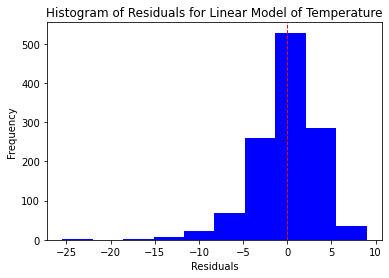

In [75]:
ax = pred_df.resid.hist(color="blue", grid=False)
ax.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
_ = ax.set(
    title="Histogram of Residuals for Linear Model of Temperature",
    xlabel="Residuals",
    ylabel="Frequency",
)

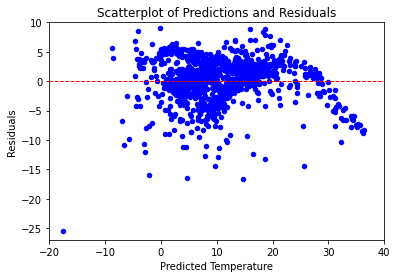

In [79]:
ax = pred_df.plot.scatter(x="prediction", y="resid", color="blue")
ax.axhline(0, color="red", linestyle="dashed", linewidth=1)
_ = ax.set(
    title="Scatterplot of Predictions and Residuals",
    xlabel="Predicted Temperature",
    ylabel="Residuals",
    xlim=(-20, 40),
    ylim=(-27, 10),
)

^ Our model over-predicts all predictions above approximately 28 degree Celsius. It is also likely to underpredict when it predicts value between 18 and 28.

Let's see if we get any better results with polynomial regression.

### Using polynomial regression

In [80]:
poly_trans = PolynomialFeatures(degree=4, include_bias=False)
poly_trans.fit(X_train.dropna())

PolynomialFeatures(degree=4, include_bias=False)

In [82]:
feature_names = poly_trans.get_feature_names(feature_cols)
feature_names

['latabs',
 'elevation',
 'latabs^2',
 'latabs elevation',
 'elevation^2',
 'latabs^3',
 'latabs^2 elevation',
 'latabs elevation^2',
 'elevation^3',
 'latabs^4',
 'latabs^3 elevation',
 'latabs^2 elevation^2',
 'latabs elevation^3',
 'elevation^4']

#### Pipeline

In [85]:
pipe2 = make_pipeline(OutlierTrans(3), knn_imp, poly_trans, StandardScaler(), lr)
ttr2 = TransformedTargetRegressor(regressor=pipe2, transformer=StandardScaler())
ttr2.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('outliertrans',
                                                      OutlierTrans(threshold=3)),
                                                     ('knnimputer',
                                                      KNNImputer(n_neighbors=45)),
                                                     ('polynomialfeatures',
                                                      PolynomialFeatures(degree=4,
                                                                         include_bias=False)),
                                                     ('standardscaler',
                                                      StandardScaler()),
                                                     ('linearregression',
                                                      LinearRegression())]),
                           transformer=StandardScaler())

#### Prediction

In [86]:
y_pred = ttr2.predict(X_test)
pred_df = (
    pd.DataFrame(y_pred, columns=["prediction"], index=X_test.index)
    .join(X_test)
    .join(y_test)
)
pred_df["resid"] = pred_df.avgtemp - pred_df.prediction

pred_df.resid.agg(["mean", "median", "skew", "kurtosis"])

mean        0.011820
median      0.197552
skew       -0.978774
kurtosis    3.342115
Name: resid, dtype: float64

^ There is a little less skew in the residuals than with the linear model.

We should take a look at a histogram of the residuals.

Text(0, 0.5, 'Frequency')

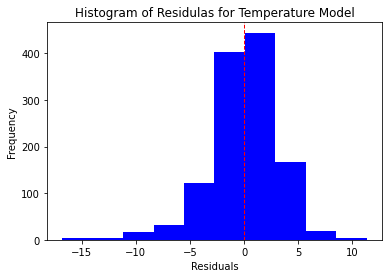

In [87]:
plt.hist(pred_df.resid, color="blue")
plt.axvline(pred_df.resid.mean(), color="red", linestyle="dashed", linewidth=1)
plt.title("Histogram of Residulas for Temperature Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

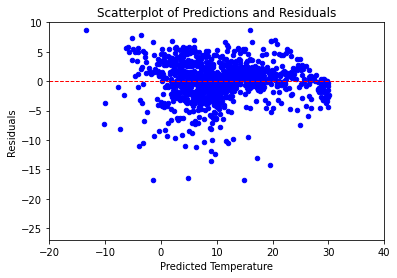

In [89]:
ax = pred_df.plot.scatter("prediction", "resid", color="blue")
ax.axhline(0, color="red", linestyle="dashed", linewidth=1)
_ = ax.set(
    title="Scatterplot of Predictions and Residuals",
    xlabel="Predicted Temperature",
    ylabel="Residuals",
    xlim=(-20, 40),
    ylim=(-27, 10),
)

In [92]:
scores = cross_validate(
    ttr2,
    X=X_train,
    y=y_train,
    cv=kf,
    scoring=("r2", "neg_mean_absolute_error"),
    n_jobs=1,
)
scores["test_r2"].mean(), scores["test_neg_mean_absolute_error"].mean()

(0.8339878897078581, -2.4005376748949887)

^ The polynomial transformation improved our overall results, particularly with certain rangoes of our predictors. The residuals at high temperatures were noticeably lower. It is often a good idea to try a polynomial transformation when our residuals suggest that there might be a nonlinear relationship between our features and our target.

## Regression with gradient descent

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from data.load import load_landtemps2019avgs
from preprocfunc import OutlierTrans

#### Load data

In [94]:
land_temps = load_landtemps2019avgs()

#### Feature selection

In [95]:
feature_cols = ["latabs", "elevation"]
target_col = ["avgtemp"]
land_temps[target_col + feature_cols].agg(["min", "median", "max"]).T

,min,median,max
avgtemp,-60.821,10.4500,33.93
latabs,0.017,40.6703,90.00
elevation,-350.000,271.3000,9999.00


#### Train-test split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    land_temps[feature_cols], land_temps[target_col], test_size=0.1, random_state=0
)

#### Pipeline

In [100]:
knn_imp = KNNImputer(n_neighbors=45)
sgdr = SGDRegressor()
pipe1 = make_pipeline(OutlierTrans(3), knn_imp, StandardScaler(), sgdr)

ttr = TransformedTargetRegressor(regressor=pipe1, transformer=StandardScaler())

#### Hyperparameter Tuning

The `huber` loss function is less sensitive to outliers than is OLS. How sensitive it is, is based on the value of epsilon we speicfy. With the `epsilon_insensitive` loss function, errors within a given range (epsilon) are not penalized. 

In [101]:
sgdr_params = {
    "regressor__sgdregressor__alpha": 10.0 ** -np.arange(1, 7),
    "regressor__sgdregressor__loss": ["huber", "epsilon_insensitive"],
    "regressor__sgdregressor__penalty": ["l2", "l1", "elasticnet"],
    "regressor__sgdregressor__epsilon": np.arange(0.1, 1.6, 0.1),
}

gs = GridSearchCV(ttr, param_grid=sgdr_params, cv=5, scoring="r2")
gs.fit(X_train, y_train)
gs.best_params_

{'regressor__sgdregressor__alpha': 0.0001,
 'regressor__sgdregressor__epsilon': 1.3000000000000003,
 'regressor__sgdregressor__loss': 'huber',
 'regressor__sgdregressor__penalty': 'l2'}

In [103]:
gs.best_score_

0.7942575347708081

In [104]:
pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["meanscore"]).join(
    pd.DataFrame(gs.cv_results_["params"])
).sort_values(["meanscore"], ascending=False).T

,342,536,260,241,258,356,433,354,343,446,...,7,81,83,87,70,89,76,82,88,1
meanscore,0.794258,0.794223,0.794153,0.794141,0.794125,0.794122,0.794122,0.794116,0.794115,0.794115,...,0.534775,0.534281,0.505582,0.4929,0.487796,0.462564,0.429271,0.36297,0.296066,-0.00822
regressor__sgdregressor__alpha,0.0001,0.000001,0.001,0.001,0.001,0.0001,0.00001,0.0001,0.0001,0.00001,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
regressor__sgdregressor__epsilon,1.3,1.5,1.4,1.1,1.4,1.5,1.3,1.5,1.3,1.5,...,0.2,1.4,1.4,1.5,1.2,1.5,1.3,1.4,1.5,0.1
regressor__sgdregressor__loss,huber,huber,huber,huber,huber,huber,huber,huber,huber,huber,...,huber,epsilon_insensitive,epsilon_insensitive,epsilon_insensitive,epsilon_insensitive,epsilon_insensitive,epsilon_insensitive,epsilon_insensitive,epsilon_insensitive,huber
regressor__sgdregressor__penalty,l2,elasticnet,elasticnet,l1,l2,elasticnet,l1,l2,l1,elasticnet,...,l1,l2,elasticnet,l2,l1,elasticnet,l1,l1,l1,l1
